In [1]:
import secrets
import pymysql
from sqlalchemy import create_engine
import sys
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

In [2]:
db_conn_str = "mysql+pymysql://{:}:{:}@{:}/{:}".format(secrets.user, secrets.password, secrets.host, secrets.db)
db_conn = create_engine(db_conn_str)

df = pd.read_sql('SELECT * FROM labelled WHERE completed = TRUE', con=db_conn)
db_conn.dispose()

In [3]:
df

,url,start,end,commentator,crowd,isHighlight,gameplay,updated_at,completed,priority,mfcc,amplitude,pitch,word,subjectivity,polarity
0,https://www.youtube.com/watch?v=02I5vVxlJhU,24,28,0,0,NaN,1,2020-02-26 22:30:23,1,10,[172.34694 59.855976 -16.23632 34.32...,-0.002607,NaN,None,None,None
1,https://www.youtube.com/watch?v=02I5vVxlJhU,40,44,0,0,NaN,1,2020-02-26 21:22:06,1,10,[ 1.8889221e+02 4.6004627e+01 -2.7908030e+00 ...,-0.002323,NaN,None,None,None
2,https://www.youtube.com/watch?v=02I5vVxlJhU,90,94,0,0,NaN,1,2020-02-27 07:19:24,1,10,[ 9.3631500e+01 9.8736382e+01 -2.8482916e+01 ...,0.000091,NaN,None,None,None
3,https://www.youtube.com/watch?v=02I5vVxlJhU,210,214,0,0,NaN,1,2020-02-27 01:53:35,1,10,[ 1.6850551e+02 6.2470104e+01 -4.0681911e+00 ...,-0.000207,NaN,None,None,None
4,https://www.youtube.com/watch?v=02I5vVxlJhU,286,290,0,0,NaN,1,2020-02-26 23:03:48,1,10,[ 1.3290944e+02 9.6197624e+01 -5.8774590e+00 ...,-0.000794,NaN,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2125,https://www.youtube.com/watch?v=vmb27NX36Lk,2756,2760,0,0,NaN,1,2020-02-28 03:20:35,1,10,[ 7.8034073e+01 9.1039940e+01 -2.5333509e+01 ...,0.001345,NaN,None,None,None
2126,https://www.youtube.com/watch?v=vmb27NX36Lk,2788,2792,0,0,NaN,0,2020-02-27 07:15:53,1,10,[28.74763 64.24063 4.241808 34.31897 ...,-0.011137,NaN,None,None,None
2127,https://www.youtube.com/watch?v=vmb27NX36Lk,2874,2878,1,0,NaN,0,2020-02-26 22:28:16,1,10,[ 93.075516 91.87269 -13.757497 22.92...,-0.083905,NaN,None,None,None
2128,https://www.youtube.com/watch?v=vmb27NX36Lk,2944,2948,0,0,NaN,1,2020-02-26 23:04:01,1,10,[ 1.16511185e+02 6.98217087e+01 -3.47451901e+...,0.008843,NaN,None,None,None


In [47]:
# converts mfcc string to a usable array
def mfccStrToArr(mfccStr):
    cleanedStr = mfccStr.replace('[', '').replace(']', '')
    str_arr = cleanedStr.split()
    result = list(map(lambda x: float(x), str_arr))
    return result

mfcc = df.iloc[0].mfcc
mfccStrToArr(mfcc)

[172.34694,
 59.855976,
 -16.23632,
 34.32595,
 -8.056751,
 17.003977,
 -1.8322253,
 12.688299,
 -2.4241674,
 7.410389,
 -3.2917688,
 11.584252,
 1.1426991,
 4.1908574,
 -4.761322,
 7.0422773,
 -3.65242,
 2.5524652,
 -2.5492988,
 5.5649633,
 -4.1712604,
 3.7507133,
 0.94055337,
 5.93649,
 -1.6665388,
 2.8610766,
 -0.31954995,
 0.6866829,
 -2.6408782,
 2.0542347,
 -2.9972253,
 1.330713,
 -2.0337555,
 2.9000976,
 -2.0899518,
 0.8820801,
 -3.838774,
 -0.71413285,
 -3.2620826,
 0.26921213]

In [48]:
# make a new column with mfcc arrays
df['mfcc_arr'] = df.apply(lambda row: mfccStrToArr(row.mfcc), axis = 1)

In [6]:
# apply tsne
featureData = df['mfcc_arr'].tolist()
tsneResult = TSNE(n_components=2).fit_transform(featureData)
tsnedf = pd.DataFrame(tsneResult, columns=['x', 'y'])


In [7]:
# append tsne values to df
df['x'] = tsnedf['x'].values
df['y'] = tsnedf['y'].values

df

,url,start,end,commentator,crowd,isHighlight,gameplay,updated_at,completed,priority,mfcc,amplitude,pitch,word,subjectivity,polarity,mfcc_arr,x,y
0,https://www.youtube.com/watch?v=02I5vVxlJhU,24,28,0,0,NaN,1,2020-02-26 22:30:23,1,10,[172.34694 59.855976 -16.23632 34.32...,-0.002607,NaN,None,None,None,"[172.34694, 59.855976, -16.23632, 34.32595, -8...",19.626850,-71.958519
1,https://www.youtube.com/watch?v=02I5vVxlJhU,40,44,0,0,NaN,1,2020-02-26 21:22:06,1,10,[ 1.8889221e+02 4.6004627e+01 -2.7908030e+00 ...,-0.002323,NaN,None,None,None,"[188.89221, 46.004627, -2.790803, 28.539114, 3...",20.688372,-71.903503
2,https://www.youtube.com/watch?v=02I5vVxlJhU,90,94,0,0,NaN,1,2020-02-27 07:19:24,1,10,[ 9.3631500e+01 9.8736382e+01 -2.8482916e+01 ...,0.000091,NaN,None,None,None,"[93.6315, 98.736382, -28.482916, 60.927795, -1...",18.998287,-10.537136
3,https://www.youtube.com/watch?v=02I5vVxlJhU,210,214,0,0,NaN,1,2020-02-27 01:53:35,1,10,[ 1.6850551e+02 6.2470104e+01 -4.0681911e+00 ...,-0.000207,NaN,None,None,None,"[168.50551, 62.470104, -4.0681911, 27.382914, ...",19.568420,-71.392838
4,https://www.youtube.com/watch?v=02I5vVxlJhU,286,290,0,0,NaN,1,2020-02-26 23:03:48,1,10,[ 1.3290944e+02 9.6197624e+01 -5.8774590e+00 ...,-0.000794,NaN,None,None,None,"[132.90944, 96.197624, -5.877459, 38.210041, 9...",3.776402,-51.631702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2125,https://www.youtube.com/watch?v=vmb27NX36Lk,2756,2760,0,0,NaN,1,2020-02-28 03:20:35,1,10,[ 7.8034073e+01 9.1039940e+01 -2.5333509e+01 ...,0.001345,NaN,None,None,None,"[78.034073, 91.03994, -25.333509, 28.731655, -...",10.863514,-7.597733
2126,https://www.youtube.com/watch?v=vmb27NX36Lk,2788,2792,0,0,NaN,0,2020-02-27 07:15:53,1,10,[28.74763 64.24063 4.241808 34.31897 ...,-0.011137,NaN,None,None,None,"[28.74763, 64.24063, 4.241808, 34.31897, 6.399...",2.598651,15.205832
2127,https://www.youtube.com/watch?v=vmb27NX36Lk,2874,2878,1,0,NaN,0,2020-02-26 22:28:16,1,10,[ 93.075516 91.87269 -13.757497 22.92...,-0.083905,NaN,None,None,None,"[93.075516, 91.87269, -13.757497, 22.929829, -...",-2.627558,-34.817520
2128,https://www.youtube.com/watch?v=vmb27NX36Lk,2944,2948,0,0,NaN,1,2020-02-26 23:04:01,1,10,[ 1.16511185e+02 6.98217087e+01 -3.47451901e+...,0.008843,NaN,None,None,None,"[116.511185, 69.8217087, -3.47451901, 29.91735...",11.559696,-45.258373


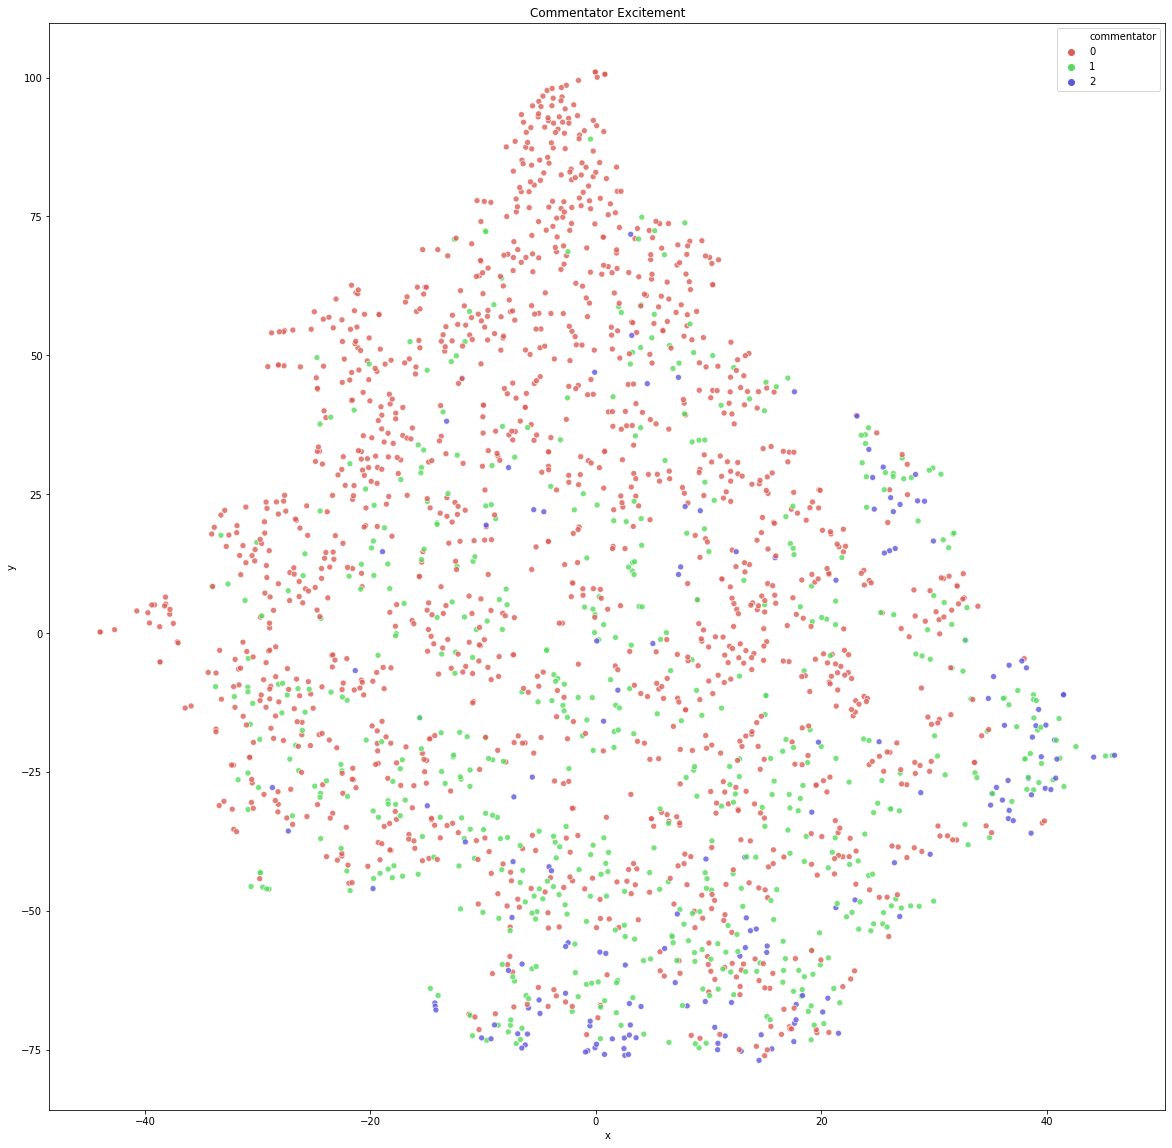

In [8]:
# plot tsne commentator excitement

plt.figure(figsize=(20,20))
plt.subplot(1,1,1)
plt.title("Commentator Excitement")
sns.scatterplot(
    x="x",
    y="y",
    hue="commentator",
    palette=sns.color_palette("hls", 3),
    data=df,
    legend="full",
    alpha=0.8
)


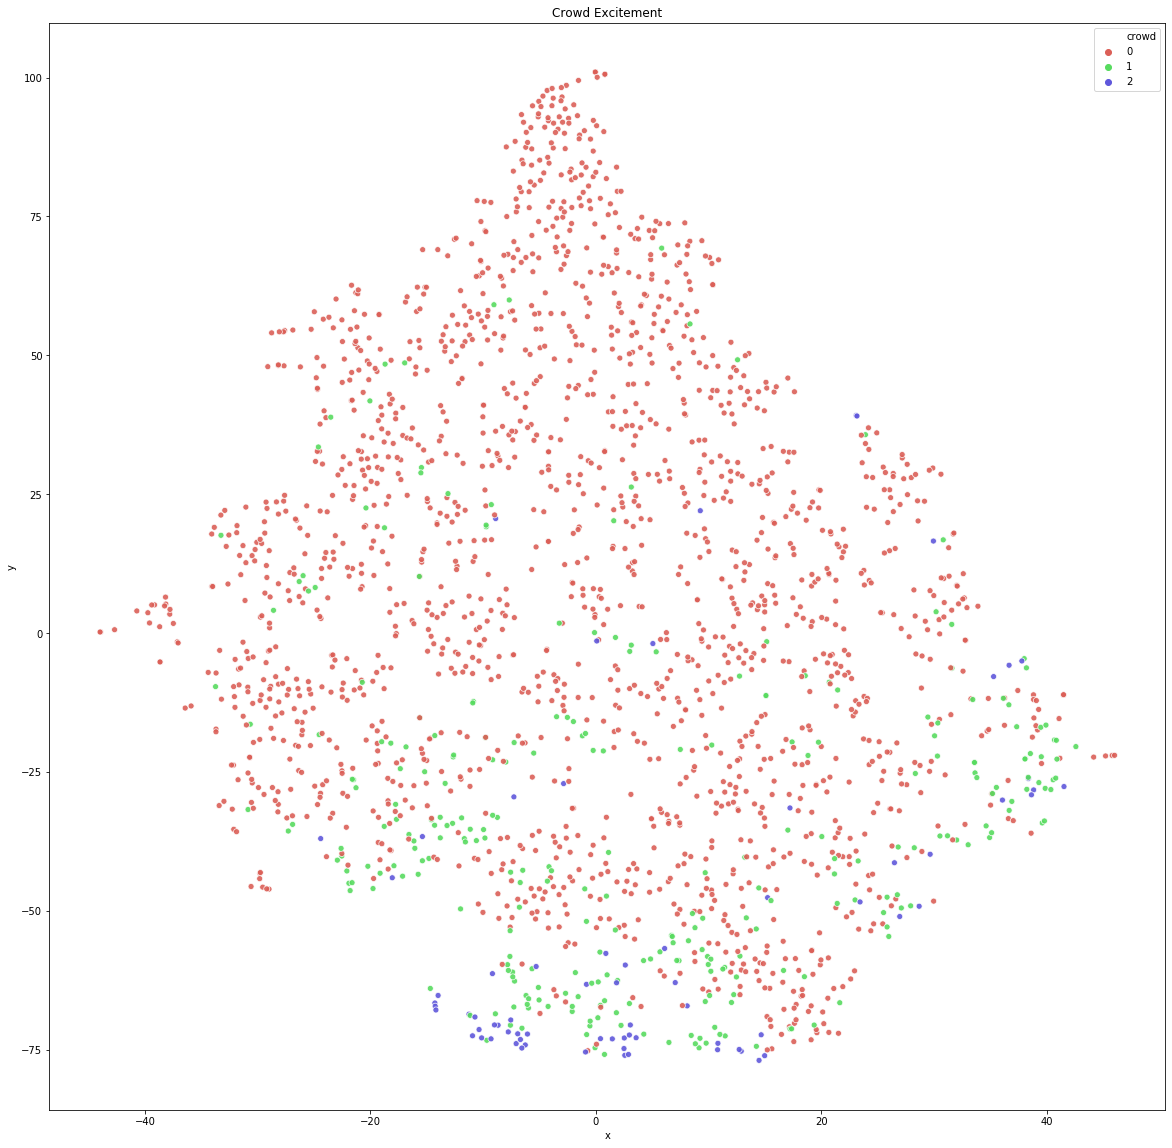

In [9]:
# plot tsne crowd excitement

plt.figure(figsize=(20,20))
plt.subplot(1,1,1)
plt.title("Crowd Excitement")
sns.scatterplot(
    x="x",
    y="y",
    hue="crowd",
    palette=sns.color_palette("hls", 3),
    data=df,
    legend="full",
    alpha=0.9
)

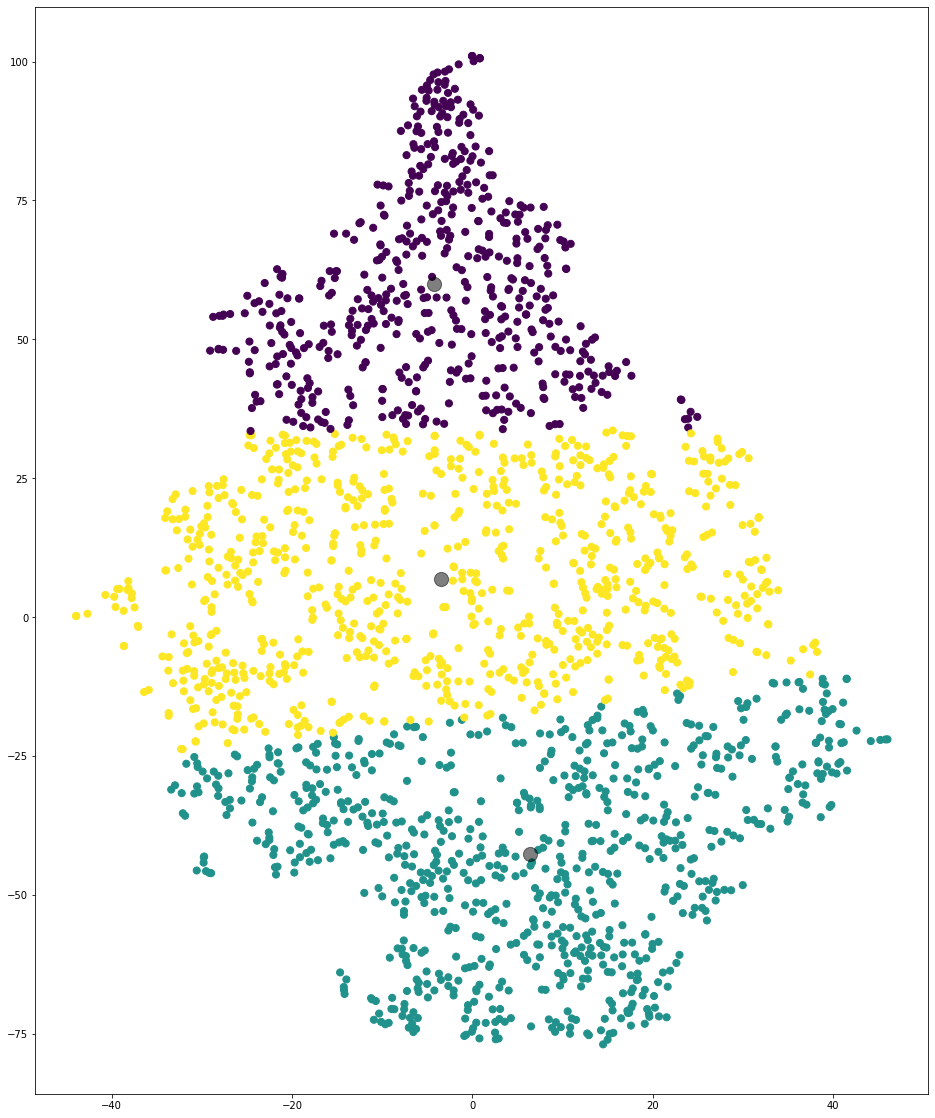

In [10]:
# lets try k means on this boi
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(df[['x', 'y']])
y_kmeans = kmeans.predict(df[['x', 'y']])

plt.figure(figsize=(16, 20))
plt.scatter(df['x'], df['y'], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [11]:
# clustering doesn't look too good should try some thing else 
# First lets split the data using k-fold
from sklearn.model_selection import KFold

kf = KFold(n_splits = 5, shuffle = True)
kfold_data = next(kf.split(df), None)

train = df.iloc[kfold_data[0]]
test = df.iloc[kfold_data[1]]

In [12]:
# Lets train svm on 3 classes
from sklearn.svm import SVC

x_coords = train['x'].values
y_coords = train['y'].values

X_train = list(zip(x_coords, y_coords))
y_train = train['commentator'].values

svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [13]:
# Run predictions and evaluate
from sklearn.metrics import classification_report, confusion_matrix

x_coords = test['x'].values
y_coords = test['y'].values

X_test = list(zip(x_coords, y_coords))
y_test = test['commentator'].values

y_pred = svclassifier.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[257   0   0]
 [127   0   0]
 [ 42   0   0]]
              precision    recall  f1-score   support

           0       0.60      1.00      0.75       257
           1       0.00      0.00      0.00       127
           2       0.00      0.00      0.00        42

    accuracy                           0.60       426
   macro avg       0.20      0.33      0.25       426
weighted avg       0.36      0.60      0.45       426



/Users/tylerlam/.pyenv/versions/3.7.6/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
# Idk why but its classifying everthing as non-excited. Might be becuase there's too many non-excited data points. 
# Make equal number of each data point

# count number of very excite
very_excite = df[df['commentator'] == 2]
num_excite = len(very_excite)

# sample num_excite # of elements from each class
no_excite = df[df['commentator'] == 0].sample(n=num_excite, replace=False)
slight_excite = df[df['commentator'] == 1].sample(n=num_excite, replace=False)
very_excite = df[df['commentator'] == 2].sample(n=num_excite, replace=False)

balanced_df = pd.concat([no_excite, slight_excite, very_excite])

X = list(zip(balanced_df['x'].values, balanced_df['y']))
y = balanced_df['y'].values

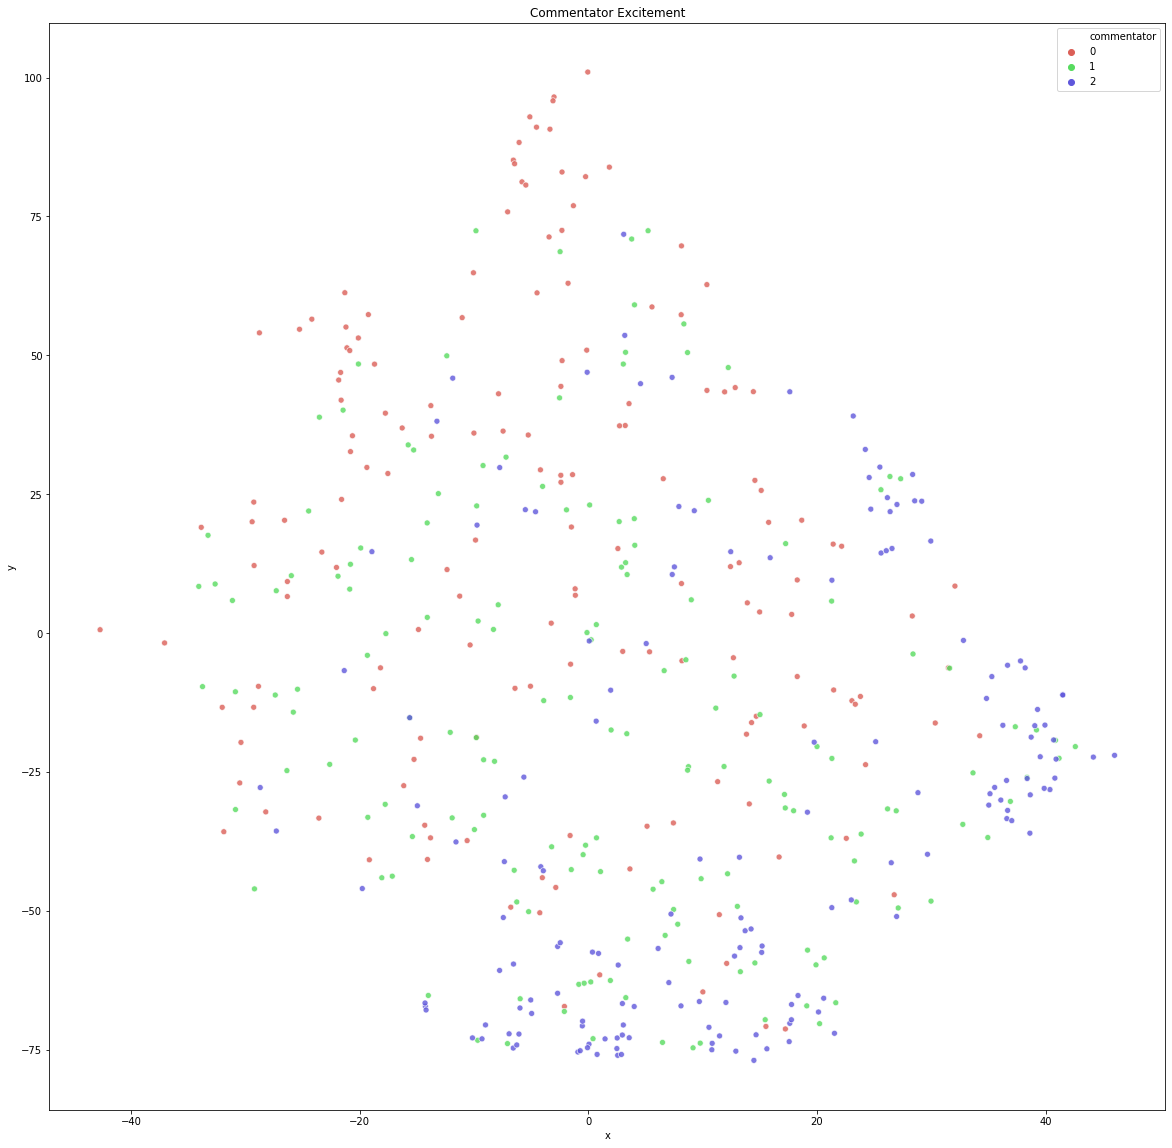

In [15]:
# plot training data
plt.figure(figsize=(20,20))
plt.subplot(1,1,1)
plt.title("Commentator Excitement")
sns.scatterplot(
    x="x",
    y="y",
    hue="commentator",
    palette=sns.color_palette("hls", 3),
    data=balanced_df,
    legend="full",
    alpha=0.8
)

In [61]:
# try training 10 svm models (1 for each fold in kfold) with 3 classes
svm_results = []
svm_models = []

for train_idx, test_idx in kf.split(balanced_df, None):
    train = balanced_df.iloc[train_idx]
    test = balanced_df.iloc[test_idx]
    
    X_train = train['mfcc_arr'].tolist()
    y_train = train['commentator']
    
    svclassifier = SVC(kernel='linear')
    svclassifier.fit(X_train, y_train)
    svm_models.append(svclassifier)
    
    X_test = test['mfcc_arr'].tolist()
    y_test = test['commentator']
    
    y_pred = svclassifier.predict(X_test)
    
    svm_results.append([y_test, y_pred])


In [62]:
# evaluate the model performance
counter = 1
for y_test, y_pred in svm_results:
    print("MODEL ", counter)
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    counter += 1

MODEL  1
[[18  9  0]
 [12 16 10]
 [ 4  8 21]]
              precision    recall  f1-score   support

           0       0.53      0.67      0.59        27
           1       0.48      0.42      0.45        38
           2       0.68      0.64      0.66        33

    accuracy                           0.56        98
   macro avg       0.56      0.57      0.57        98
weighted avg       0.56      0.56      0.56        98

MODEL  2
[[24  7  3]
 [11 18  7]
 [ 0  5 22]]
              precision    recall  f1-score   support

           0       0.69      0.71      0.70        34
           1       0.60      0.50      0.55        36
           2       0.69      0.81      0.75        27

    accuracy                           0.66        97
   macro avg       0.66      0.67      0.66        97
weighted avg       0.65      0.66      0.65        97

MODEL  3
[[22 12  1]
 [12 15  3]
 [ 3 10 19]]
              precision    recall  f1-score   support

           0       0.59      0.63      0.61  

ValueError: X.shape[1] = 2 should be equal to 40, the number of features at training time

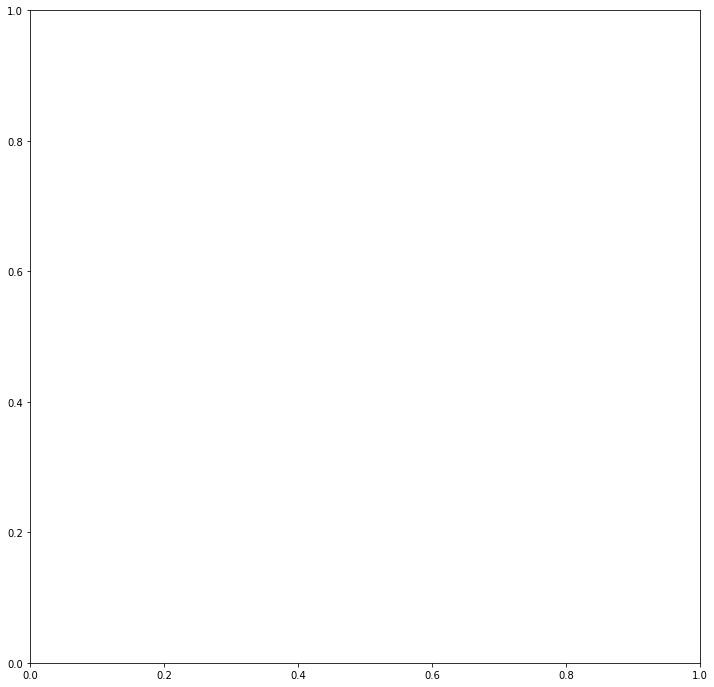

In [63]:
# that looks a lot better
# Model 2 looks the best based on the precision and recall compared to the other models

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

fig, ax = plt.subplots(figsize=(12,12))
title = ('Decision surface of linear SVC ')
X0, X1 = balanced_df['x'], balanced_df['y']
xx, yy = make_meshgrid(X0, X1)
y = balanced_df['commentator']
model = svm_models[1]

plot_contours(ax, model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()

In [65]:
# lets try training with different svm types instead of just linear
# try training svm with 3 classes using polynomial
svm_results_poly = []
svm_models_poly = []

for train_idx, test_idx in kf.split(balanced_df, None):
    train = balanced_df.iloc[train_idx]
    test = balanced_df.iloc[test_idx]
    
    X_train = train['mfcc_arr'].tolist()
    y_train = train['commentator']
    
    svclassifier = SVC(kernel='poly')
    svclassifier.fit(X_train, y_train)
    svm_models_poly.append(svclassifier)
    
    X_test = test['mfcc_arr'].tolist()
    y_test = test['commentator']
    
    y_pred = svclassifier.predict(X_test)
    
    svm_results_poly.append([y_test, y_pred])

In [66]:
# evaluate the model performance
counter = 1
for y_test, y_pred in svm_results:
    print("MODEL ", counter)
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    counter += 1

MODEL  1
[[18  9  0]
 [12 16 10]
 [ 4  8 21]]
              precision    recall  f1-score   support

           0       0.53      0.67      0.59        27
           1       0.48      0.42      0.45        38
           2       0.68      0.64      0.66        33

    accuracy                           0.56        98
   macro avg       0.56      0.57      0.57        98
weighted avg       0.56      0.56      0.56        98

MODEL  2
[[24  7  3]
 [11 18  7]
 [ 0  5 22]]
              precision    recall  f1-score   support

           0       0.69      0.71      0.70        34
           1       0.60      0.50      0.55        36
           2       0.69      0.81      0.75        27

    accuracy                           0.66        97
   macro avg       0.66      0.67      0.66        97
weighted avg       0.65      0.66      0.65        97

MODEL  3
[[22 12  1]
 [12 15  3]
 [ 3 10 19]]
              precision    recall  f1-score   support

           0       0.59      0.63      0.61  

ValueError: X.shape[1] = 2 should be equal to 40, the number of features at training time

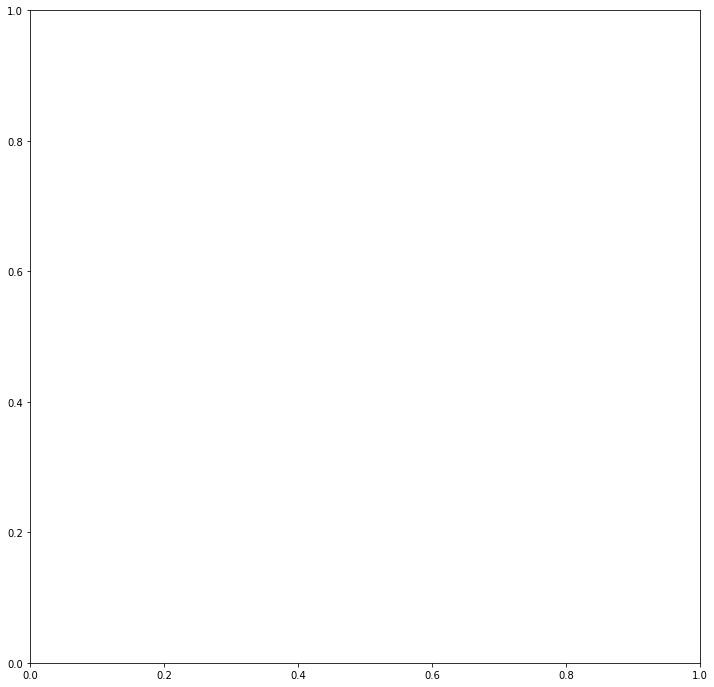

In [67]:
# model 2 looks the best here based on precision and recall
# lets plot it
fig, ax = plt.subplots(figsize=(12,12))
title = ('Decision surface of poly SVC ')
X0, X1 = balanced_df['x'], balanced_df['y']
xx, yy = make_meshgrid(X0, X1)
y = balanced_df['commentator']
model = svm_models_poly[1]

plot_contours(ax, model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()

In [69]:
# lets try testing using model 7 linear svm on a larger set of data
svclassifier_linear = svm_models[1]

X_test = df['mfcc_arr'].tolist()
y_test = df['commentator']

y_pred = svclassifier_linear.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[967 323  86]
 [173 283 136]
 [  6  30 126]]
              precision    recall  f1-score   support

           0       0.84      0.70      0.77      1376
           1       0.44      0.48      0.46       592
           2       0.36      0.78      0.49       162

    accuracy                           0.65      2130
   macro avg       0.55      0.65      0.57      2130
weighted avg       0.70      0.65      0.66      2130



In [70]:
# lets try testing using model 5 svm poly on a larger set of data
svclassifier_poly = svm_models_poly[1]

X_test = df['mfcc_arr'].tolist()
y_test = df['commentator']

y_pred = svclassifier_poly.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))


[[910 418  48]
 [171 306 115]
 [ 22  28 112]]
              precision    recall  f1-score   support

           0       0.83      0.66      0.73      1376
           1       0.41      0.52      0.46       592
           2       0.41      0.69      0.51       162

    accuracy                           0.62      2130
   macro avg       0.55      0.62      0.57      2130
weighted avg       0.68      0.62      0.64      2130



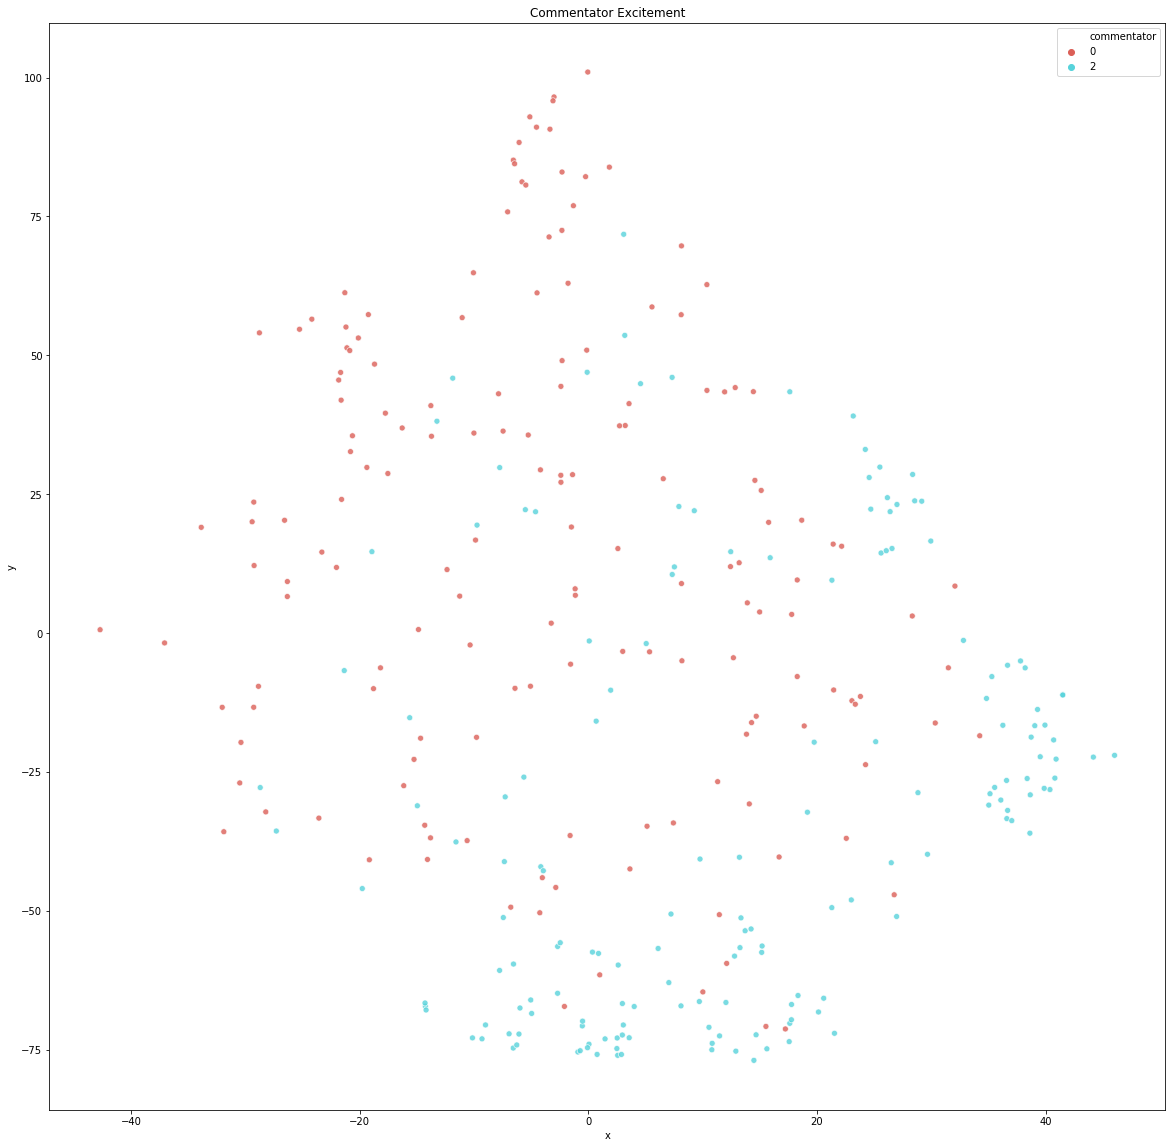

In [26]:
# lets try dropping slightly excited as a class and only classifying 0 and 2 
df_exclude_slightly = balanced_df[balanced_df['commentator'] != 1]

# plot data
plt.figure(figsize=(20,20))
plt.subplot(1,1,1)
plt.title("Commentator Excitement")
sns.scatterplot(
    x="x",
    y="y",
    hue="commentator",
    palette=sns.color_palette("hls", 2),
    data=df_exclude_slightly,
    legend="full",
    alpha=0.8
)


In [71]:
# train the svm model linear again
svm_results_exclude = []
svm_models_exclude = []

for train_idx, test_idx in kf.split(df_exclude_slightly, None):
    train = df_exclude_slightly.iloc[train_idx]
    test = df_exclude_slightly.iloc[test_idx]
    
    X_train = train['mfcc_arr'].tolist()
    y_train = train['commentator']
    
    svclassifier = SVC(kernel='linear')
    svclassifier.fit(X_train, y_train)
    svm_models_exclude.append(svclassifier)
    
    X_test = test['mfcc_arr'].tolist()
    y_test = test['commentator']
    
    y_pred = svclassifier.predict(X_test)
    
    svm_results_exclude.append([y_test, y_pred])

In [72]:
# evaluate the model performance
counter = 1
for y_test, y_pred in svm_results_exclude:
    print("MODEL ", counter)
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    counter += 1

MODEL  1
[[32  2]
 [ 4 27]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.91        34
           2       0.93      0.87      0.90        31

    accuracy                           0.91        65
   macro avg       0.91      0.91      0.91        65
weighted avg       0.91      0.91      0.91        65

MODEL  2
[[26  3]
 [ 4 32]]
              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           2       0.91      0.89      0.90        36

    accuracy                           0.89        65
   macro avg       0.89      0.89      0.89        65
weighted avg       0.89      0.89      0.89        65

MODEL  3
[[33  6]
 [ 4 22]]
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        39
           2       0.79      0.85      0.81        26

    accuracy                           0.85        65
   macro avg       0.84      0.85      0.84 

In [78]:
# lets try testing using model 1 svm linear slightly excluded on a larger set of data
svclassifier_exclude = svm_models_exclude[0]

X_test = df_exclude_slightly['mfcc_arr'].tolist()
y_test = df_exclude_slightly['commentator']

y_pred = svclassifier_exclude.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[155   7]
 [ 11 151]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       162
           2       0.96      0.93      0.94       162

    accuracy                           0.94       324
   macro avg       0.94      0.94      0.94       324
weighted avg       0.94      0.94      0.94       324



No handles with labels found to put in legend.


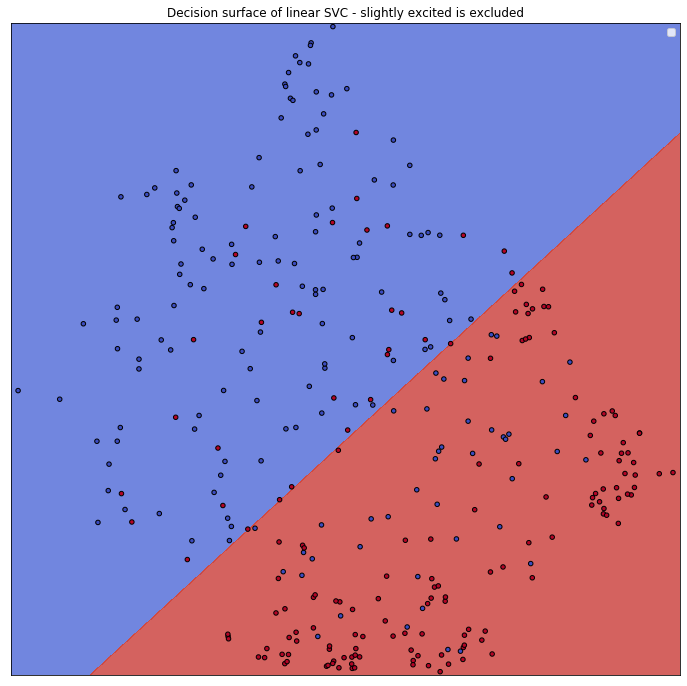

In [29]:
# Model 6 looks the best here 
# lets plot it
fig, ax = plt.subplots(figsize=(12,12))
title = ('Decision surface of linear SVC - slightly excited is excluded')
X0, X1 = df_exclude_slightly['x'], df_exclude_slightly['y']
xx, yy = make_meshgrid(X0, X1)
y = df_exclude_slightly['commentator']
model = svm_models_exclude[2]

plot_contours(ax, model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()

In [73]:
# try rbf svm
svm_results_rbf = []
svm_models_rbf = []

for train_idx, test_idx in kf.split(balanced_df, None):
    train = balanced_df.iloc[train_idx]
    test = balanced_df.iloc[test_idx]
    
    X_train = train['mfcc_arr'].tolist()
    y_train = train['commentator']
    
    svclassifier = SVC(kernel='rbf')
    svclassifier.fit(X_train, y_train)
    svm_models_rbf.append(svclassifier)
    
    X_test = test['mfcc_arr'].tolist()
    y_test = test['commentator']
    
    y_pred = svclassifier.predict(X_test)
    
    svm_results_rbf.append([y_test, y_pred])

In [75]:
# evaluate the model performance
counter = 1
for y_test, y_pred in svm_results_rbf:
    print("MODEL ", counter)
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    counter += 1

MODEL  1
[[24 13  2]
 [ 8 12 10]
 [ 1  2 26]]
              precision    recall  f1-score   support

           0       0.73      0.62      0.67        39
           1       0.44      0.40      0.42        30
           2       0.68      0.90      0.78        29

    accuracy                           0.63        98
   macro avg       0.62      0.64      0.62        98
weighted avg       0.63      0.63      0.62        98

MODEL  2
[[17  7  3]
 [12 14  7]
 [ 2 12 23]]
              precision    recall  f1-score   support

           0       0.55      0.63      0.59        27
           1       0.42      0.42      0.42        33
           2       0.70      0.62      0.66        37

    accuracy                           0.56        97
   macro avg       0.56      0.56      0.56        97
weighted avg       0.56      0.56      0.56        97

MODEL  3
[[23 10  2]
 [ 4 13  9]
 [ 2  5 29]]
              precision    recall  f1-score   support

           0       0.79      0.66      0.72  

In [76]:
# lets try testing using model 5 svm rbf on a larger set of data
svclassifier_rbf = svm_models_rbf[2]

X_test = df['mfcc_arr'].tolist()
y_test = df['commentator']

y_pred = svclassifier_rbf.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[792 491  93]
 [105 326 161]
 [  6  33 123]]
              precision    recall  f1-score   support

           0       0.88      0.58      0.70      1376
           1       0.38      0.55      0.45       592
           2       0.33      0.76      0.46       162

    accuracy                           0.58      2130
   macro avg       0.53      0.63      0.53      2130
weighted avg       0.70      0.58      0.61      2130



In [81]:
# save the models so they can be used later
import pickle

svm_linear_1 = svm_models[1]
filename = 'svm_linear_1.sav'
pickle.dump(svm_linear_1, open(filename, 'wb'))

In [82]:
filename = 'svm_rbf_1.sav'
pickle.dump(svclassifier_rbf, open(filename, 'wb'))

In [83]:
filename = 'svm_poly_1.sav'
pickle.dump(svclassifier_poly, open(filename, 'wb'))

In [84]:
filename = 'svm_linear_exclude_1.sav'
pickle.dump(svclassifier_exclude, open(filename, 'wb'))